<a href="https://colab.research.google.com/github/JuanCappelletti/Consteel_H06/blob/main/torre_comportanmiento%20energetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

#@title Ejecutar librerias { run: "auto", display-mode: "form" }
from matplotlib.font_manager import json_dump
from numpy.matrixlib.defmatrix import N
from operator import truediv
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objects as go
from IPython.display import Image
import math
def calcular_temperatura_bulbo_humedo(T, RH):
    # Cálculos intermedios
    part1 = 0.151977 * math.sqrt(RH + 8.313659)
    part2 = math.atan(T + RH)
    part3 = math.atan(RH -1.676331)
    part4 = 0.00391838 *(RH**(3/2)) * math.atan(0.023101 * RH)
    # Cálculo de la temperatura de bulbo húmedo (Tw)
    Tw = round((T * math.atan (part1) + part2 - part3 + part4 - 4.686035),2)
    return Tw


# ***Process flow diagram***

---
## ***Referencias:***
- Supply Flow (Water to Steel Mill)= QS
- Total Return flow ( Water from Steel Mill)= QRT
- Return Flow (chilled water, represent approximately 70% of the return flow total water ) = QR
- By-pass Flow (proportional non chilled water, represent approximately 30% of the return flow total water )= QBY
- Make-up Flow (water replenishment) = QM
- Overflow Flow = QO
- Temperature return Water (measured in pipe)= tr
- Temperature pool Water (equilibrium temperature) = tp
- Temperature enviroment = te


Mounted at /content/drive


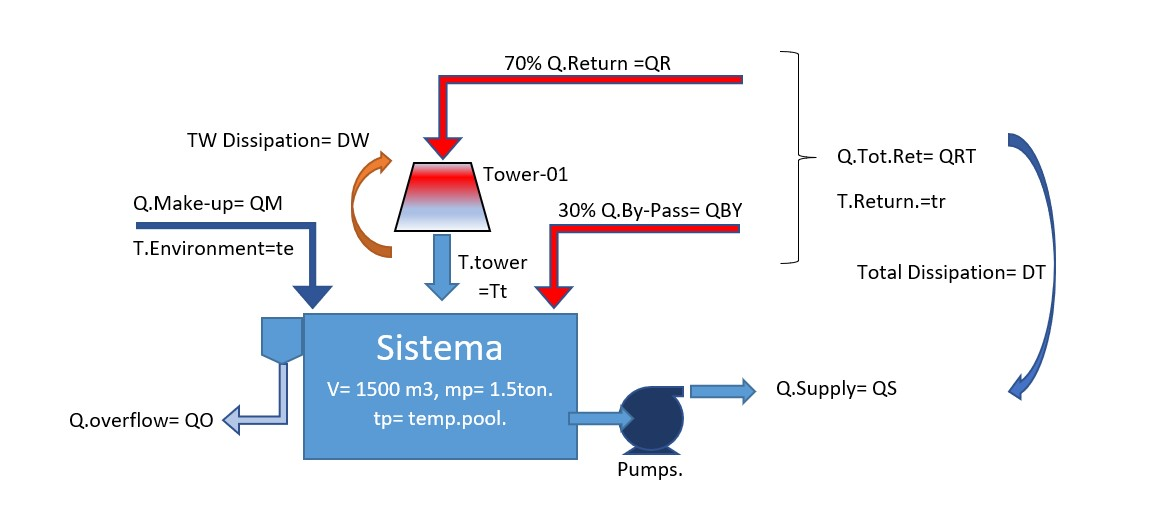

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
Image('/content/drive/MyDrive/ESQUEMATORRE.jpg',width=1000)


In [ ]:

from prompt_toolkit.layout.dimension import D
#@title "Ejecutar Celda"
Url = "https://raw.githubusercontent.com/JuanCappelletti/Consteel_H06/main/TOMA%20TEMP.csv" #@param {type:"string"}
tab = True # @param {type:"boolean"}
datos = pd.read_csv(Url,sep=",",decimal=".")
df=pd.DataFrame(datos)
dfx=df.copy()
if tab:
   print(dfx)


Cantidad de items sampleados:  1441
Fecha de la muestra:  12/2/2023 -  05:00:00 al 13/2/2323 -  05:00:00
Muestreo cada 1 minuto


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


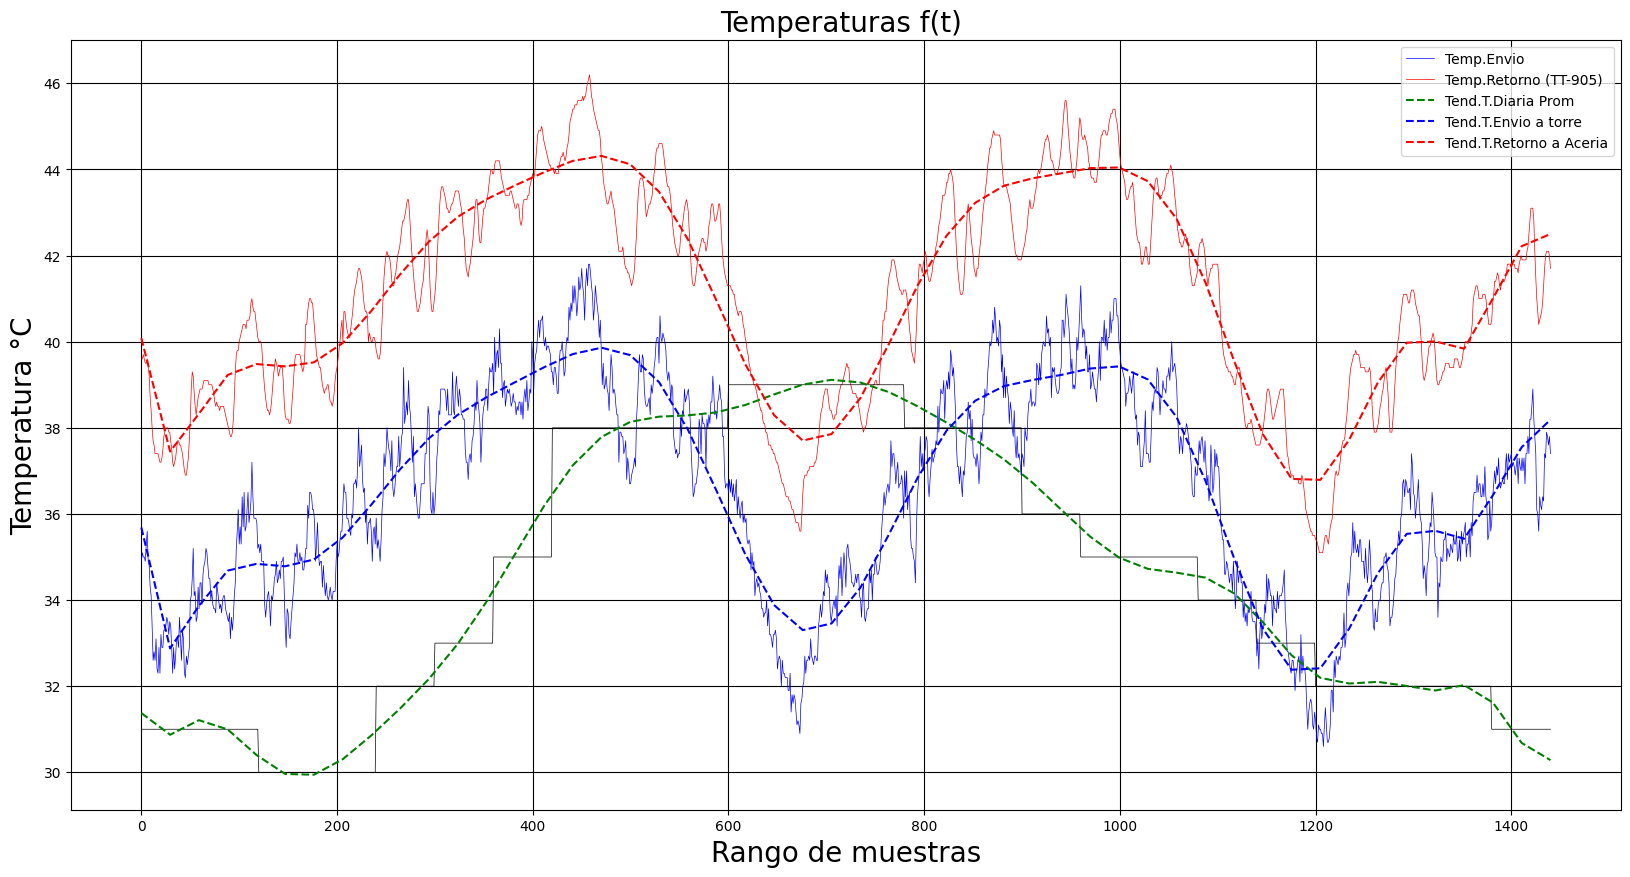

In [ ]:
from matplotlib.ticker import AutoLocator
from io import DEFAULT_BUFFER_SIZE
from matplotlib.ticker import MaxNLocator
#@title Seleccionar parametros y ejecuar celda
#InstrumentoParametro = 'PIR171' #@param {type:"raw"}
#x = 'FQI171' #@param {type:"raw"}
#y = 'PIR171' #@param {type:"raw"}
text='Caudal Nm3/h'
text1='Presión kg/cm2'
text2='Rango de muestras'
text3='Temperatura °C'
print('Cantidad de items sampleados: ', len(dfx.index))
print('Fecha de la muestra: ',dfx.date[0],'-',dfx.time[0], 'al',dfx.date[(len(dfx.index)-1)],'-',dfx.time[(len(dfx.index)-1)])
print('Muestreo cada 1 minuto')

# Grado del polinomio de tendencia (ajusta según tus necesidades)
grado_polinomio = 30

# Ajustar el polinomio de tendencia a los datos
coefficients = np.polyfit( dfx.index,dfx['TDIA'], grado_polinomio)
coefficients1 = np.polyfit( dfx.index,dfx['TTORRE'], grado_polinomio)
coefficients2 = np.polyfit( dfx.index,dfx['TRETORNO'], grado_polinomio)
polynomial = np.poly1d(coefficients)
polynomial1 = np.poly1d(coefficients1)
polynomial2 = np.poly1d(coefficients2)
# Crear valores x para la línea de tendencia
x_trendline = np.linspace(dfx.index.min(), dfx.index.max())
x_trendline1 = np.linspace(dfx.index.min(), dfx.index.max())
x_trendline2 = np.linspace(dfx.index.min(), dfx.index.max())
# Calcular valores y correspondientes para la línea de tendencia polinómica
y_trendline = polynomial(x_trendline)
y_trendline1 = polynomial1(x_trendline1)
y_trendline2 = polynomial2(x_trendline2)


# Grestion final del gradico .......
fig, (ax1)= plt.subplots(1, figsize=(20,10))
ax1.plot(dfx.index,dfx['TTORRE'],linewidth=0.5,color='blue',label=f'Temp.Envio')
ax1.plot(dfx.index,dfx['TRETORNO'],linewidth=0.5,color='red',label=f'Temp.Retorno (TT-905)')
ax1.plot(dfx.index,dfx['TDIA'],linewidth=0.5,color='black')
ax1.plot(x_trendline, y_trendline, label=f'Tend.T.Diaria Prom', color='green',linestyle='--')
ax1.plot(x_trendline1, y_trendline1, label=f'Tend.T.Envio a torre', color='blue',linestyle='--')
ax1.plot(x_trendline2, y_trendline2, label=f'Tend.T.Retorno a Aceria', color='red',linestyle='--')
ax1.set_title('Temperaturas f(t) ',fontsize=20)
ax1.set_xlabel(text2,fontsize=20)
ax1.set_ylabel(text3,fontsize=20)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
labels2 = ax1.get_xticklabels()
labels3= ax1.get_yticklabels()
plt.setp(labels3,fontsize=10, horizontalalignment='right')
ax1.axes.grid(True, which='minor',color='grey',axis='both')
ax1.axes.grid(True, which='major',color='black',axis='both')
ax1.legend()

# Mostrar el gráfico
plt.show()





           date       time  QENTRADA  REPOSICION  QRETORNO  TTORRE  TRETORNO  \
0     12/2/2023   05:00:00     11240         280     11510    34.9      39.6   
1     12/2/2023   05:01:00     11480         270     11590    35.1      39.6   
2     12/2/2023   05:02:00     11350         240     11620    35.0      39.7   
3     12/2/2023   05:03:00     11370         280     11730    35.0      39.6   
4     12/2/2023   05:04:00     11270         285     11670    34.9      39.5   
...         ...        ...       ...         ...       ...     ...       ...   
1436  13/2/2319   04:56:00     11290         263     11450    37.9      42.1   
1437  13/2/2320   04:57:00     11220         259     11650    37.8      42.1   
1438  13/2/2321   04:58:00     11240         268     11630    37.6      42.1   
1439  13/2/2322   04:59:00     11300         304     11680    37.8      42.0   
1440  13/2/2323   05:00:00     11310         289     11590    37.4      41.7   

      TDIA  DISIPTOTAL  POTENTRADA  POT

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


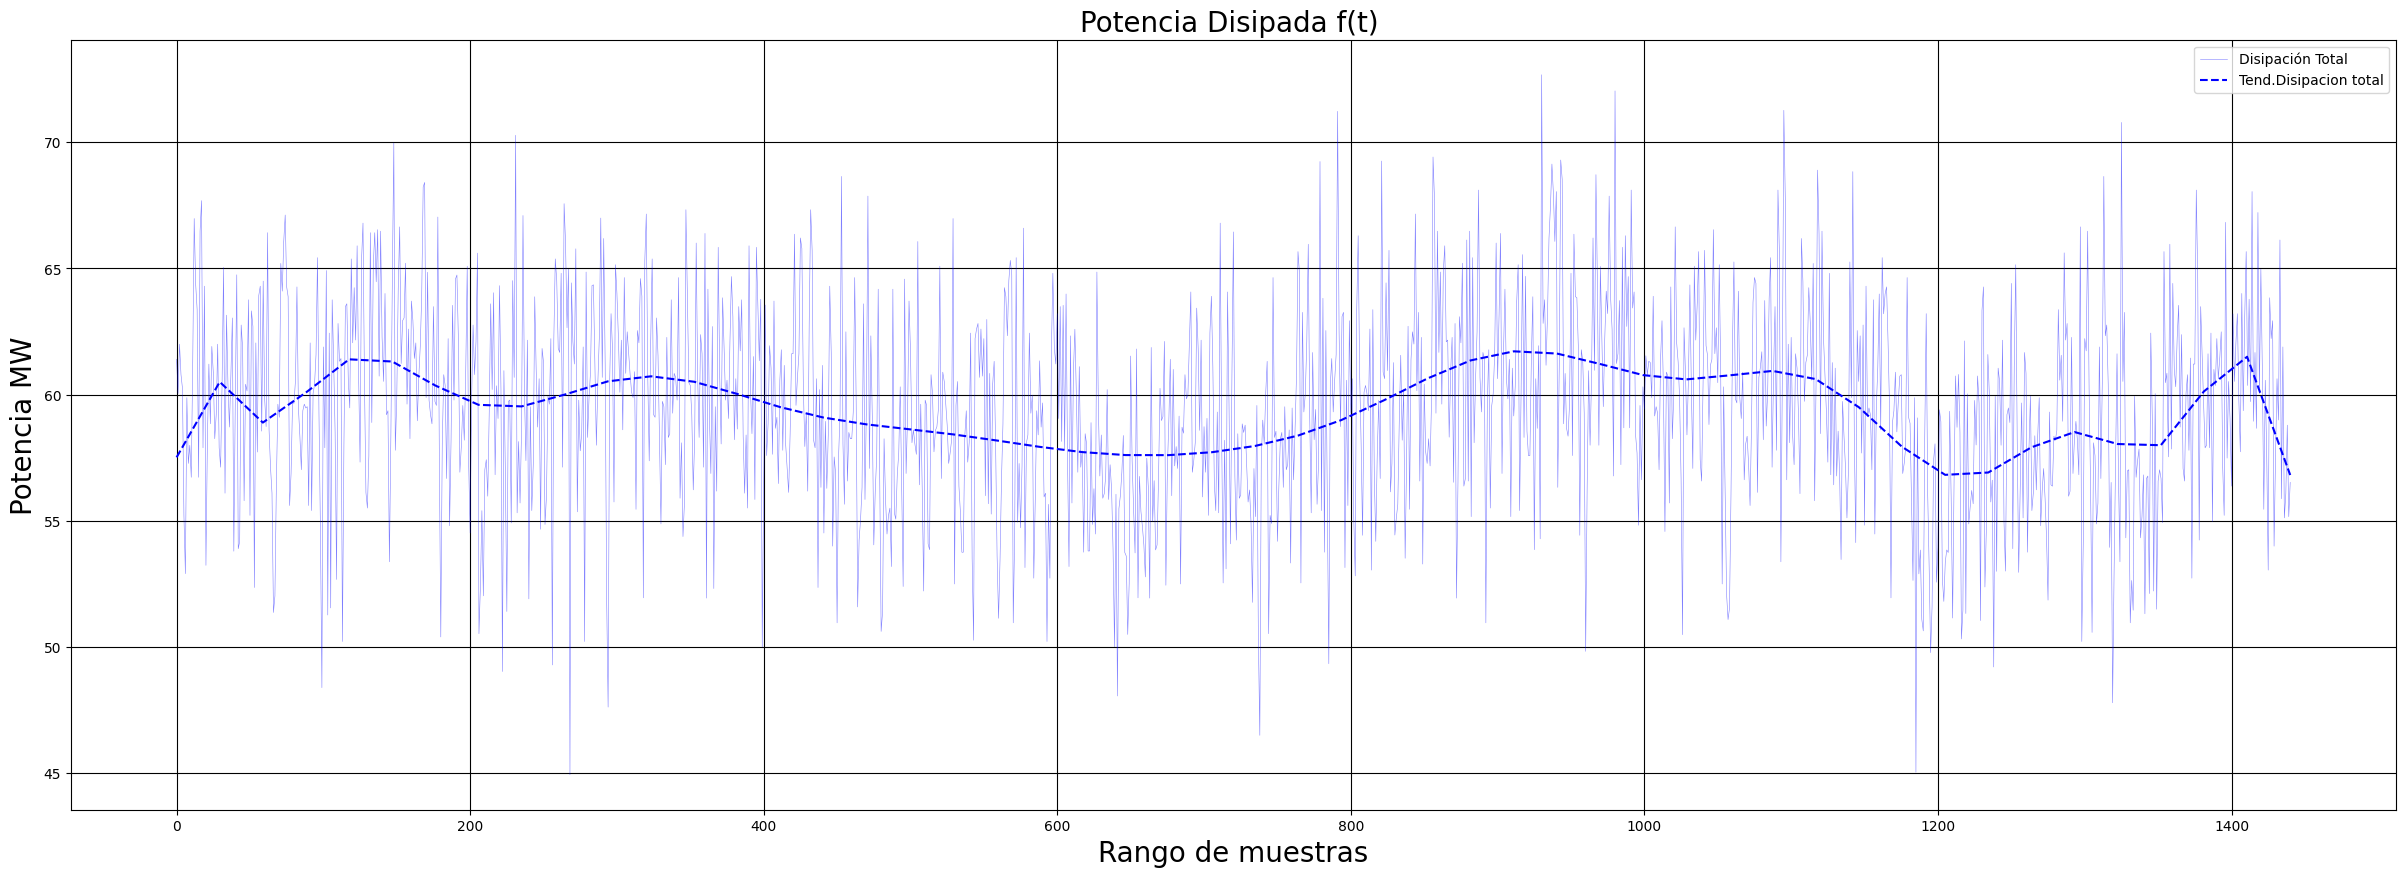

In [ ]:
dfa = df.copy()
dfa['DISIPTOTAL'] = 0.0  # Inicializa la columna como float
dfa['POTENTRADA'] = 0.0  # Inicializa la columna como float
dfa['POTMAKEUP'] = 0.0  # Inicializa la columna como float

for i in range(len(dfa)):
    valor = dfa['QENTRADA'][i]
    AUX = round(((valor / 3600) * 1000 * 4184 * (dfa['TRETORNO'][i] - dfa['TTORRE'][i])) / 1000000, 2)
    dfa.at[i, 'DISIPTOTAL'] = AUX  # Asigna el valor calculado a la columna 'DISIPTOTAL'

for i in range(len(dfa)):
    valor = dfa['QENTRADA'][i]
    AUX = round(((valor / 3600) * 1000 * 4184 * ((dfa['TRETORNO'][i]*0.03) )-dfa['TTORRE'][i]) / 1000000, 2)
    dfa.at[i, 'POTENTRADA'] = AUX

for i in range(len(dfa)):
    valor = dfa['REPOSICION'][i]
    AUX = round(((valor / 3600) * 1000 * 4184 * ((dfa['TTORRE'][i]*0.03) )-dfa['TDIA'][i]) / 1000000, 2)
    dfa.at[i, 'POTMAKEUP'] = AUX

# Luego, muestra información sobre el DataFrame
#dfa.info()
print(dfa)

# Grado del polinomio de tendencia (ajusta según tus necesidades)
grado_polinomio = 30

# Ajustar el polinomio de tendencia a los datos
coefficients = np.polyfit( dfa.index,dfa['DISIPTOTAL'], grado_polinomio)
polynomial = np.poly1d(coefficients)
x_trendline = np.linspace(dfa.index.min(), dfa.index.max())
y_trendline = polynomial(x_trendline)


from matplotlib.ticker import MaxNLocator

text='Caudal Nm3/h'
text1='Presión kg/cm2'
text2='Rango de muestras'
text3='Potencia MW'

print('Cantidad de items sampleados: ', len(dfx.index))
print('Fecha de la muestra: ',dfx.date[0],'-',dfx.time[0], 'al',dfx.date[(len(dfx.index)-1)],'-',dfx.time[(len(dfx.index)-1)])
print('Muestreo cada 1 minuto')

# Crear el gráfico
fig, (ax1) = plt.subplots(1, figsize=(30, 10))
ax1.plot(dfa.index, dfa['DISIPTOTAL'], linewidth=0.4, color='blue', label='Disipación Total', alpha=0.5)
ax1.plot(x_trendline, y_trendline, label=f'Tend.Disipacion total', color='blue',linestyle='--')
ax1.set_title('Potencia Disipada f(t) ', fontsize=20)
ax1.set_xlabel(text2, fontsize=20)
ax1.set_ylabel(text3, fontsize=20)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

labels2 = ax1.get_xticklabels()
labels3 = ax1.get_yticklabels()
plt.setp(labels3, fontsize=10, horizontalalignment='right')
ax1.axes.grid(True, which='minor', color='grey', axis='both')
ax1.axes.grid(True, which='major', color='black', axis='both')
ax1.legend()

# Mostrar el gráfico
plt.show()


In [29]:



# Ejemplo de uso
T = 31.0  # Temperatura en °C
RH = 62.1  # Humedad relativa en porcentaje (%)

temperatura_bulbo_humedo = calcular_temperatura_bulbo_humedo(T, RH)
print("Temperatura de bulbo húmedo:", temperatura_bulbo_humedo, "°C")

Temperatura de bulbo húmedo: 25.24 °C


In [30]:
import math

# Coeficientes de Magnus
a = 17.625
b = 243.04

def calcular_punto_rocio(T, RH):
    alpha = math.log((RH/100),math.e) + (17.625 * T) / (243.04 + T)
    Ts = (243.04 * alpha) / (17.625 - alpha)
    return Ts

# Ejemplo de uso
T = 31.0  # Temperatura en grados Celsius (°C)
RH = 62.1
  # Humedad relativa en porcentaje (%)

punto_rocio = calcular_punto_rocio(T, RH)
print("Punto de rocío:", punto_rocio, "°C")

Punto de rocío: 22.89457679688447 °C


In [32]:
import math

def calcular_humedad_relativa(T, Dp):
    # Coeficientes de Magnus
    a = 17.625
    b = 243.04

    # Calcular RH usando la fórmula
    numerador = math.exp(a * Dp / (b + Dp))
    denominador = math.exp(a * T / (b + T))
    RH = 100 * (numerador / denominador)

    return RH

# Ejemplo de uso
T = 31.0  # Temperatura en °C
Dp = 15  # Punto de rocío en °C

humedad_relativa = calcular_humedad_relativa(T, Dp)
print("Humedad relativa:", humedad_relativa, "%")

Humedad relativa: 37.937587025645456 %
